# Creation of datasets for finetuning LLMs on arXiv abstracts

Useful info can be found here: https://info.arxiv.org/help/arxiv_identifier_for_services.html

# Outline

- [ 1 - Packages and setup](#1)
    - [1.1 - Log into huggingface hub](#1.1)
- [ 2 - Load full arXiv metadata (currently ~4.2Gb)](#2)
- [ 3 - Data manipulation](#3)
    - [3.1 - Identify small set of papers which we authored](#3.1)
    - [3.2 - Explore categories](#3.2)
    - [3.3 - Extract specific category/categories](#3.3)
    - [3.4 - Remove papers that have been withdrawn](#3.4)
- [ 4 - Look at the abstracts](#4)    
    - [4.1 - Length of abstracts](#4.1)
    - [4.2 - Keywords/PACS at end of abstracts](#4.2)
    - [4.3 - Multi-lingual abstracts](#4.3)
    - [4.4 - Look at distribution of dates from `id` column](#4.4)
- [ 5 - Clean the abstract data](#5)
- [ 6 - Convert to Huggingface dataset and push](#6)
    - [ 6.1 - Convert Pandas DataFrame to dataset Dataset](#6.1)
    - [ 6.2 - Split dataset into train, test and validation datasets](#6.2)
    - [ 6.3 - Upload data to Huggingface](#6.3)

<a name="1"></a>
## 1 - Packages and setup

In [1]:
import numpy as np 
import pandas as pd
import json
import re

import huggingface_hub
import datasets

<a name="1.1"></a>
### 1.1 - Log into huggingface hub

In [2]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("HFapi")
    huggingface_hub.login(secret_value_0)
except:
    huggingface_hub.login()

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


<a name="2"></a>
## 2 - Load full arXiv metadata (currently ~4.2Gb)

The Kaggle dataset is described here: https://www.kaggle.com/datasets/Cornell-University/arxiv

In this notebook we've pinned the dataset to be v193 which includes submissions upto around 22nd August 2024.


Arxiv submissions are tightly controlled and should follow the instructions given here https://info.arxiv.org/help/prep.html.

In particular, the Title and Abstract metadata must be in ASCII input and Unicode characters should be converted to LaTex equivalent.
Since ASCII is a subset of utf-8 we can use utf-8 encoding to parse the json file.

In [3]:
df_dir='/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json'
json_data = []

with open(df_dir, 'r', encoding='utf-8') as f:
    for line in f:
        # Parse JSON from each line
        try:
            json_object = json.loads(line)
            json_data.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue
            
df = pd.DataFrame(json_data)
del json_data

<a name="3"></a>
## 3 - Data manipulation

In [4]:
df.shape

(2542615, 14)

In [5]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


<a name="3.1"></a>
### 3.1 - Identify small set of papers which we authored

We want to create a very small control dataset so we can see how well a LLM completes abstracts as it is being finetuned.

We choose the id of the paper which appears as the $n$th entry in each of our inspires record (Sid not included as no hep-th papers)
with $n = \text{entry number of citeable papers} \, // \, 2$.

In [6]:
ids = ["1804.08625", "1404.0016", "1205.2086", "1209.5915", "1802.05268"]
df_overfit = df[df['id'].isin(ids)]
df_overfit

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
341087,1205.2086,Vasilis Niarchos,Vasilis Niarchos,Seiberg dualities and the 3d/4d connection,"harvmac, 17 pages",None,10.1007/JHEP07(2012)075,CCTP-2012-07,hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We discuss the degeneration limits of d=4 su...,"[{'version': 'v1', 'created': 'Wed, 9 May 2012...",2015-06-05,"[[Niarchos, Vasilis, ]]"
373079,1209.5915,Michal P. Heller,"Jan de Boer, Borun D. Chowdhury, Michal P. Hel...",Towards a holographic realization of the quark...,"31 pages, 16 figures; v2: inset plot in Fig. 1...","Phys. Rev. D 87, 066009 (2013)",10.1103/PhysRevD.87.066009,None,hep-th hep-ph nucl-th,http://arxiv.org/licenses/nonexclusive-distrib...,Large-N_c QCD matter at intermediate baryon ...,"[{'version': 'v1', 'created': 'Wed, 26 Sep 201...",2013-03-28,"[[de Boer, Jan, ], [Chowdhury, Borun D., ], [H..."
513069,1404.0016,Constantinos Papageorgakis,Constantinos Papageorgakis and Andrew B. Royston,Revisiting Soliton Contributions to Perturbati...,"Latex, 25 pages; v2: Clarifications added and ...",None,10.1007/JHEP09(2014)128,"RUNHETC-2014-03, QMUL-PH-14-06, MIFPA-14-09",hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,It is often said that soliton contributions ...,"[{'version': 'v1', 'created': 'Mon, 31 Mar 201...",2020-08-04,"[[Papageorgakis, Constantinos, ], [Royston, An..."
944808,1802.05268,Jaewon Song,"Prarit Agarwal, Kazunobu Maruyoshi, Jaewon Song","A ""Lagrangian"" for the E7 Superconformal Theory","13 pages + appendices, v2: typos corrected",None,10.1007/JHEP05(2018)193,"SNUTP18-001, KIAS-P18021",hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We find an N=1 gauge theory that flows to th...,"[{'version': 'v1', 'created': 'Wed, 14 Feb 201...",2018-07-04,"[[Agarwal, Prarit, ], [Maruyoshi, Kazunobu, ],..."
970318,1804.08625,Pietro Benetti Genolini,"Pietro Benetti Genolini, Paul Richmond, James ...",Gravitational free energy in topological AdS/CFT,"46 pages; v2: corrected typos, updated references",JHEP 1809 (2018) 100,10.1007/JHEP09(2018)100,None,hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We define and study a holographic dual to th...,"[{'version': 'v1', 'created': 'Mon, 23 Apr 201...",2018-09-21,"[[Genolini, Pietro Benetti, ], [Richmond, Paul..."


In [7]:
# remove our papers from main dataframe so we don't double count
df = df[~df['id'].isin(ids)]

<a name="3.2"></a>
### 3.2 - Explore categories

See https://arxiv.org/category_taxonomy for a desciption of the values which can appear.
Each arXiv article has a primary category and may also have one or more cross-lists to other categories.

Inspecting `df.head()` we see that `df.iloc[1]['categories'] = 'math.CO cs.CG'`. The *primary* classifcation is `math.CO` and it is also cross-listed to the `cs.BG` category.

In [8]:
# there are many combinations of primary and cross-list categories
df['categories'].value_counts()

categories
astro-ph                                                            86911
hep-ph                                                              81611
quant-ph                                                            70092
cs.CV                                                               60946
hep-th                                                              59147
                                                                    ...  
physics.hist-ph astro-ph.IM eess.SP                                     1
physics.plasm-ph cond-mat.mtrl-sci cond-mat.soft physics.flu-dyn        1
cs.NA cs.NE physics.comp-ph                                             1
physics.soc-ph nucl-ex physics.ins-det                                  1
supr-con cond-mat.supr-con quant-ph                                     1
Name: count, Length: 84868, dtype: int64

In [9]:
# split string appearing in `categories` on white space and expand
# split_cats[0] is the *primary* classification
split_cats = df['categories'].str.split(n=-1, expand=True)
primary_cat = split_cats[0]

In [10]:
# get a list of primary classifications and associated count
# list is ordered in descending count  
primary_cats_and_counts = list(zip(split_cats[0].value_counts().keys().tolist(), split_cats[0].value_counts().tolist()))
primary_cats_and_counts

[('hep-ph', 132678),
 ('quant-ph', 109916),
 ('hep-th', 105617),
 ('cs.CV', 99967),
 ('astro-ph', 94246),
 ('cs.LG', 87968),
 ('gr-qc', 63776),
 ('cond-mat.mes-hall', 63246),
 ('cond-mat.mtrl-sci', 60664),
 ('cs.CL', 51717),
 ('math.AP', 48821),
 ('cond-mat.str-el', 47924),
 ('astro-ph.GA', 46346),
 ('math.CO', 45184),
 ('astro-ph.SR', 43046),
 ('cond-mat.stat-mech', 40585),
 ('astro-ph.CO', 40024),
 ('astro-ph.HE', 39238),
 ('math.PR', 38798),
 ('math.AG', 35704),
 ('cs.IT', 35461),
 ('nucl-th', 33374),
 ('math.NT', 32267),
 ('math-ph', 31717),
 ('math.OC', 31480),
 ('cond-mat.supr-con', 31443),
 ('physics.optics', 29206),
 ('math.DG', 28872),
 ('math.NA', 28631),
 ('cond-mat.soft', 28076),
 ('cs.RO', 24310),
 ('hep-ex', 23111),
 ('math.DS', 22575),
 ('cs.CR', 22570),
 ('cs.AI', 22356),
 ('astro-ph.EP', 22309),
 ('math.FA', 19889),
 ('stat.ME', 19555),
 ('physics.flu-dyn', 19071),
 ('astro-ph.IM', 17963),
 ('hep-lat', 17952),
 ('stat.ML', 16779),
 ('eess.SP', 16132),
 ('cs.NI', 16004)

<a name="3.3"></a>
### 3.3 - Extract specific category/categories

In [11]:
wanted_categories = ['hep-th', 'hep-ph', 'gr-qc']

In [12]:
# we get those papers whose *primary* classification is in `wanted_categories`
df = df[primary_cat.apply(lambda x: any(k in x for k in wanted_categories))]
# uncomment line below to get papers where `wanted_categories` is also in cross-listing
# df = df[df['categories'].apply(lambda x: any(k in x for k in wanted_categories))]

In [13]:
df.shape

(302071, 14)

<a name="3.4"></a>
### 3.4 - Remove papers that have been withdrawn

See https://info.arxiv.org/help/withdraw.html

In [14]:
# make an index of comments which contain either 'Withdrawn' or 'withdrawn'
withdrawn = df['comments'].str.contains('Withdrawn', case=False) # empty comments return None
withdrawn.fillna(value=False, inplace=True) # replace None with False
withdrawn.value_counts()

/tmp/ipykernel_18/270111922.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  withdrawn.fillna(value=False, inplace=True) # replace None with False


comments
False    301353
True        718
Name: count, dtype: int64

In [15]:
# sanity check but takes a while
# make an index of abstracts which contain either 'Withdrawn' or 'withdrawn'
# this way is quicker than using contains('withdrawn', case=False)
withdrawn_abs = df['abstract'].str.contains('Withdrawn') | df['abstract'].str.contains('withdrawn') #| df['abstract'].str.contains('removed') 
withdrawn_abs.value_counts()

abstract
False    301720
True        351
Name: count, dtype: int64

In [16]:
# look at entries with `withdrawn` in abstract but not in comments
df[~withdrawn & withdrawn_abs]

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
71809,0807.0816,Patricio Gaete,Patricio Gaete and Iv\'an Schmidt,Confinement effects from massive photons,4 pages,None,None,USM-TH-235,hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,This paper has been withdrawn by the author ...,"[{'version': 'v1', 'created': 'Fri, 4 Jul 2008...",2010-04-12,"[[Gaete, Patricio, ], [Schmidt, Iván, ]]"
72463,0807.1470,Eef van Beveren,"Xiang Liu, Eef van Beveren and George Rupp",New c-cbar structure around 3764 MeV at BES an...,"6 pages standard LaTeX, 2 figures",None,None,None,hep-ph hep-ex,http://arxiv.org/licenses/nonexclusive-distrib...,This paper has been withdrawn by the authors...,"[{'version': 'v1', 'created': 'Wed, 9 Jul 2008...",2008-07-10,"[[Liu, Xiang, ], [van Beveren, Eef, ], [Rupp, ..."
100279,0812.4153,Rahul Sinha,Rahul Sinha,Implications of CKM Unitarity on the search fo...,"4 pages, 3 figures",None,None,None,hep-ph,http://arxiv.org/licenses/nonexclusive-distrib...,This paper has been temporarily withdrawn by...,"[{'version': 'v1', 'created': 'Mon, 22 Dec 200...",2008-12-30,"[[Sinha, Rahul, ]]"
122963,0905.1367,Klein David,David Klein and Peter Collas,Exact Fermi coordinates for anti-de Sitter and...,This paper has been extended and improved unde...,None,None,None,gr-qc,http://arxiv.org/licenses/nonexclusive-distrib...,This paper has been withdrawn by the authors...,"[{'version': 'v1', 'created': 'Sat, 9 May 2009...",2010-01-08,"[[Klein, David, ], [Collas, Peter, ]]"
317129,1201.5142,Bernd Berg,Bernd A. Berg,Detection of a small shift in a broad distribu...,"13 pages, 21 figures, revised after referee re...",None,None,None,hep-ph hep-ex physics.comp-ph physics.data-an,http://arxiv.org/licenses/nonexclusive-distrib...,Statistical methods for the extraction of a ...,"[{'version': 'v1', 'created': 'Tue, 24 Jan 201...",2014-12-19,"[[Berg, Bernd A., ]]"
2298555,gr-qc/0106012,I. B. Khriplovich,I.B. Khriplovich,Quantization and entropy of black holes,"5 pages, LaTeX; revised version",None,None,None,gr-qc hep-th,None,The spectrum of the area operator for a Schw...,"[{'version': 'v1', 'created': 'Tue, 5 Jun 2001...",2007-05-23,"[[Khriplovich, I. B., ]]"
2299748,gr-qc/0205093,Matt Visser,Matt Visser (Washington University in Saint Lo...,Nonlinear realizations of Lorentz symmetry,None,None,None,None,gr-qc hep-th,None,This paper withdrawn -- it has been revised ...,"[{'version': 'v1', 'created': 'Tue, 21 May 200...",2007-05-23,"[[Visser, Matt, , Washington University in Sai..."
2302774,gr-qc/0407019,Gustavo Cionco,"A. Brunini, R. G. Cionco",Modelling Disk-Planet Interactions in N-Body N...,"11 pages, 11 figures",None,None,None,gr-qc astro-ph,None,We have withdrawn this paper because we have...,"[{'version': 'v1', 'created': 'Mon, 5 Jul 2004...",2007-05-23,"[[Brunini, A., ], [Cionco, R. G., ]]"
2302873,gr-qc/0408001,Martin Tajmar,"C.J. de Matos, M. Tajmar",Gravitomagnetic Fields in Rotating Superconduc...,None,None,None,None,gr-qc,None,This paper has been withdrawn by the authors...,"[{'version': 'v1', 'created': 'Fri, 30 Jul 200...",2007-05-23,"[[de Matos, C. J., ], [Tajmar, M., ]]"
2306918,gr-qc/0612174,Jia-Chen Hua,"Jia-Chen Hua (1), Yong-Chang Huang (2, 3) ((1)...",Quantum Radiation of General Nonstationary Bla...,This paper has been revised and will appear in...,"Europhys.Lett.85:30007,2009",10.1209/0295-5075/85/30007,None,gr-qc,http://arxiv.org/licenses/nonexclusive-distrib...,This paper has been withdrawn by the authors...,"[{'version': 'v1', 'created': 'Thu, 28 Dec 200...",2010-11-30,"[[Hua, Jia-Chen, ], [Huang, Yong-Chang, ]]"


In [17]:
# drop the withdrawn papers
df = df[~(withdrawn | withdrawn_abs)]
df.shape

(301293, 14)

<a name="4"></a>
## 4 - Look at the abstracts

<a name="4.1"></a>
### 4.1 - Length of abstracts

In [18]:
df.reset_index(drop=True, inplace=True)

In [19]:
# get the number of characters in each abstract
abstract_len = df['abstract'].map(lambda x: len(x))
# look at the summary statistics for abstract_len
abstract_len.describe()
# According to https://info.arxiv.org/help/prep.html
# abstracts longer than 1920 characters are not accepted. 
# So when did this rule begin as we have examples of abstract_len > 1920?

count    301293.000000
mean        793.992439
std         373.427542
min          16.000000
25%         517.000000
50%         737.000000
75%        1018.000000
max        2939.000000
Name: abstract, dtype: float64

<Axes: >

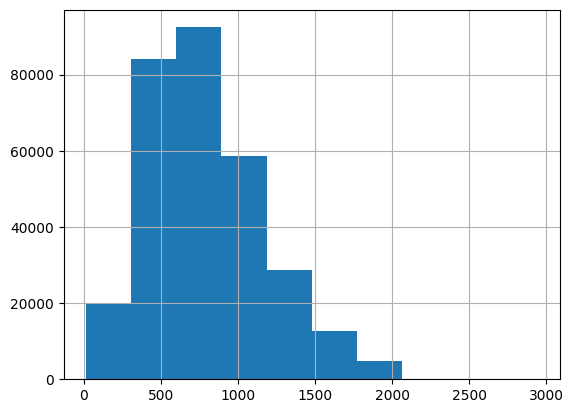

In [20]:
abstract_len.hist()

In [21]:
# Take a look at the longest abstract
df.iloc[abstract_len.idxmax()]['abstract']

"  We argue about the (non) existence of {\\it superregular} scalar clouds (i.e.,\nbound states of a massive and complex-valued scalar field $\\Psi$) around exact\n{\\it extremal} ($a = M$) Kerr black holes (BH's) possessing {\\it bounded radial\nderivatives at the horizon} (in Boyer-Lindquist coordinates) as opposed to\nsimilar cloud solutions that exist but with unbounded derivatives in the same\ncoordinate system. The latter solutions have been reported recently both\nanalytically and numerically. The superregular clouds cannot be obtained from\nthe regular clouds around subextremal Kerr BH's ($|a|< M$) in the limit of\nextremality $(a\\rightarrow M)$ as in this limit the radial derivatives of\n$\\Psi$ at the horizon $r_H$ diverge when $r_H\\rightarrow r_H^{\\rm ext}:=M=a$,\nthus, such superregular clouds must be analyzed separately. We conclude that\nthe superregular clouds, which are found in the {\\it exact} extremal scenario\n($a = M$), are not continuously connected with the re

Things to notice about the above abstract
- there is lots of whitespace at the start
- there are many \n instead of spaces

This suggests we replace \n with ' ' and strip out the extra leading/trailing whitespaces.

<a name="4.2"></a>
### 4.2 - Keywords/PACS at end of abstracts

In [22]:
# Turns out there's PACS numbers and Keywords at the end of some abstracts,
# should we remove these for training a LLM?
# Find which abstracts contain either 'Keyword' or 'PACS'
has_keyword = df['abstract'].str.contains('Keyword|PACS', case=False)
df[has_keyword].shape[0]

273

In [23]:
df[has_keyword].iloc[0]['abstract']

"  A new kind of gauge theory is introduced, where the minimal coupling and\ncorresponding covariant derivatives are defined in the space of functions\npertaining to the functional Schroedinger picture of a given field theory.\nWhile, for simplicity, we study the example of a U(1) symmetry, this kind of\ngauge theory can accommodate other symmetries as well. We consider the\nresulting relativistic nonlinear extension of quantum mechanics and show that\nit incorporates gravity in the (0+1)-dimensional limit, similar to recently\nstudied Schroedinger-Newton equations. Gravity is encoded here into a universal\nnonlinear extension of quantum theory. A probabilistic interpretation (Born's\nrule) holds, provided the underlying model is scale free.\n  Keywords: nonlinear functional Schroedinger equation, gauge symmetry,\nNewtonian gravity.\n"

In [24]:
df[has_keyword].iloc[1]['abstract']

"  We propose a simple quantum field theoretical toy model for black hole\nevaporation and study the back-reaction of Hawking radiation onto the classical\nbackground. It turns out that the horizon is also ``pushed back'' in this\nsituation (i.e., the interior region shrinks) but this back-reaction is not\ncaused by energy conservation but by momentum balance. The effective heat\ncapacity and the induced entropy variation can have both signs -- depending on\nthe parameters of the model. PACS: 04.62.+v, 04.70.Dy.\n"

In [25]:
print(f"Percentage of abstacts with Keywords or PACS is {100 * df[has_keyword].shape[0] / df.shape[0]:.3f}%")

Percentage of abstacts with Keywords or PACS is 0.091%


<a name="4.3"></a>
### 4.3 - Multi-lingual abstracts

See https://info.arxiv.org/help/faq/multilang.html

First we find any multi-lingual abstracts

In [26]:
multi = df['abstract'].str.contains("-----")
multi.value_counts()

abstract
False    301286
True          7
Name: count, dtype: int64

In [27]:
print(f"Percentage of multi-lingual abstacts is {100 * df[multi].shape[0] / df.shape[0]:.3f}%")

Percentage of multi-lingual abstacts is 0.002%


In [28]:
english_only = df['abstract'].apply(lambda x: x.split("-----")[0])

We have to be careful because there are some abstracts which have metric signatures denoted by $+-----$ as can be seen below!

In [29]:
df[multi]['abstract'].iloc[3]

"  We show in this article how the usual hamiltonian formalism of General\nRelativity should be modified in order to allow the inclusion of the Euclidean\nclassical solutions of Einstein's equations. We study the effect that the\ndynamical change of signature has on the superspace and we prove that it\ninduces a passage of the signature of the supermetric from ($-+++++$) to\n($+-----$). Next, all these features are more particularly studied on the\nexample of minisuperspaces. Finally, we consider the problem of quantization of\nthe Euclidean solutions. The consequences of different choices of boundary\nconditions are examined.\n"

To remove the "-----" and everything after it we would use the following

In [30]:
english_only = df['abstract'].apply(lambda x: x.split("-----")[0])

However, since there are very few examples we leave things as they are

## 4.4 - Look at distribution of dates from `id` column

Old scheme identifiers are of the form hep-th/9901001.

New scheme identifiers are of the form 0704.0001 or 1501.00001

In [31]:
# The dataframes look to be ordered by identifier
df['id'][:-10]

0              0704.0001
1              0704.0007
2              0704.0015
3              0704.0016
4              0704.0018
               ...      
301278    hep-th/9912280
301279    hep-th/9912281
301280    hep-th/9912282
301281    hep-th/9912283
301282    hep-th/9912284
Name: id, Length: 301283, dtype: object

In [32]:
def get_year_from_id(id):
    if '.' in id:
        year = id[:2]
    else:
        tmp = id.split('/')[1]
        year = tmp[:2]
    if year[0] == '9':
        year = '19' + year
    else:
        year = '20' + year
    return year

In [33]:
years = df['id'].map(get_year_from_id)

<Axes: >

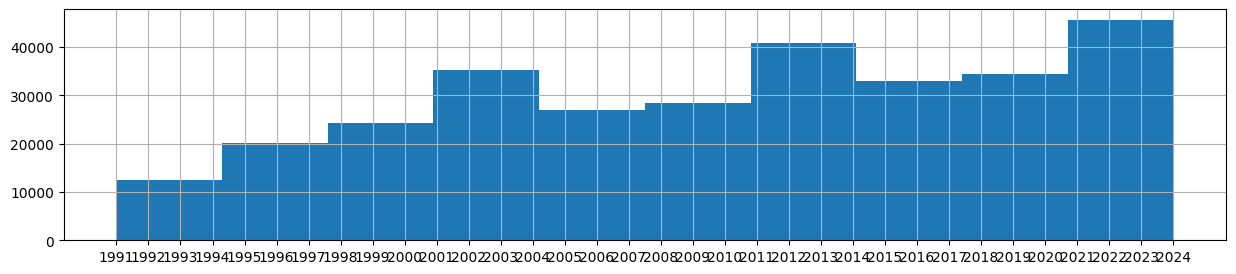

In [34]:
years.sort_values(ascending=True).hist(figsize=(15,3))

<a name="5"></a>
## 5 - Clean the abstract data

In [35]:
def clean_abstracts(abstract):
    abstract = re.sub(r'\n\s*', ' ', abstract)  # replace '\n' and any whitespace immediately after it with a single whitespace
    abstract = abstract.strip()  # remove leading/trailing whitespace
    return abstract

In [36]:
# apply `clean_abstracts` function to Series. Don't know how to do this inplace
# so we add a new column and then do some renaming
df['cleaned_abstract'] = df['abstract'].map(clean_abstracts)
df = df.rename(columns={"abstract": "orig_abstract", "cleaned_abstract": "abstract"})

In [37]:
df['abstract'].iloc[0]

'A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. All next-to-leading order perturbative contributions from quark-antiquark, gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as all-orders resummation of initial-state gluon radiation valid at next-to-next-to-leading logarithmic accuracy. The region of phase space is specified in which the calculation is most reliable. Good agreement is demonstrated with data from the Fermilab Tevatron, and predictions are made for more detailed tests with CDF and DO data. Predictions are shown for distributions of diphoton pairs produced at the energy of the Large Hadron Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs boson are contrasted with those produced from QCD processes at the LHC, showing that enhanced sensitivity to the signal can be obtained with judicious selection of events.'

<a name="6"></a>
## 6 - Convert to Huggingface dataset and push

<a name="6.1"></a>
### 6.1 - Convert Pandas DataFrame to dataset Dataset

In [38]:
raw_dataset = datasets.Dataset.from_pandas(df, preserve_index=False)

<a name="6.2"></a>
### 6.2 - Split dataset into train, test and validation datasets

use `?datasets.Dataset.train_test_split` to get full documentation

Since the DataFrame seems to be ordered by `id` column we must randomly shuffle before splitting

In [39]:
# define train/test/validation splits
train_size = 0.7 # use 70% of the dataset for training, 30% for testing & validation
validation_size = 0.5 # test_size is 1 - validation_size

In [40]:
train_testvalid = raw_dataset.train_test_split(train_size=train_size, seed=42, shuffle=True)
test_valid = train_testvalid['test'].train_test_split(test_size=validation_size, seed=42, shuffle=True)

train_test_valid_dataset = datasets.DatasetDict({'train': train_testvalid['train'],
                                                 'test': test_valid['test'],
                                                 'validation': test_valid['train']})

In [41]:
# print the number of entries in each dataset
for name, data in train_test_valid_dataset.items():
    print(f"Dataset {name} has size {data.shape[0]}")

Dataset train has size 210905
Dataset test has size 45194
Dataset validation has size 45194


<a name="6.3"></a>
### 6.3 - Upload data to Huggingface

See `?datasets.Dataset.push_to_hub` for full documentation

In [42]:
# Name for new dataset repository
repo_id = "LLMsForHepth/test"

# Add an optional commit message, default in `push_to_hub` is `"Upload dataset"`
commit_message = None
# commit_message = """
# Updated arXiv data to v193 on Kaggle. 
# Dataset now retains all arXiv metadata.
# Removed data which also appears in LLMsForHepth/arxiv_hepth_first_overfit dataset.
# Applied dataset.shuffle before train_test_split.
# """

In [43]:
# Push the Dataset to Huggingface
try:
    train_test_valid_dataset.push_to_hub(repo_id, commit_message=commit_message)
except:
    huggingface_hub.create_repo(repo_id=repo_id,
                                repo_type="dataset",
                                private=True,
                                commit_message=commit_message)
    train_test_valid_dataset.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/211 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/46 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/46 [00:00<?, ?ba/s]

In [44]:
# logout from Huggingface
huggingface_hub.logout()

Successfully logged out.


****NB: we can get previous instances of datasets by using****

```
ds_old = datasets.load_dataset('LLMsForHepth/arxiv_hepth_first', 
                               revision='346140be7a01f109af9845a0e3742b9fcd66fd9a')
                               ```
                               
where '346140be7a01f109af9845a0e3742b9fcd66fd9a' is a commit hash found on the repo website